In [40]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import ImageGrid

import os
import glob
import pandas as pd
import json

In [44]:
def get_db(data_dir):
    json_files = glob.glob(os.path.join(data_dir, "*.json"))
    data_list = []

    # Iterate through the JSON files and read them
    for file in json_files:
        with open(file, 'r') as f:
            data = json.load(f)
            data_list.append(data)

    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(data_list)
    return df

In [53]:
data_dir = "/cluster/scratch/vogtva/data/gray_scott/"
df = get_db(data_dir)

In [54]:
# df = df[df['run_id'] == "vary_du_dv"]
df

,model,A,B,Nx,dx,Nt,dt,Du,Dv,sigma_ic,random_seed,n_snapshots,filename,run_id
0,gray_scott,0.03,0.033,400,0.5,50000,0.0025,2.0,22.0,0.1,1,100,/cluster/scratch/vogtva/data/gray_scott/48b5dd...,gs_vary_ab
1,gray_scott,0.03,0.036,400,0.5,50000,0.0025,2.0,22.0,0.1,1,100,/cluster/scratch/vogtva/data/gray_scott/772901...,gs_vary_ab
2,gray_scott,0.03,0.030,400,0.5,50000,0.0025,2.0,22.0,0.1,1,100,/cluster/scratch/vogtva/data/gray_scott/91e306...,gs_vary_ab
3,gray_scott,0.03,0.039,400,0.5,50000,0.0025,2.0,22.0,0.1,1,100,/cluster/scratch/vogtva/data/gray_scott/57aff0...,gs_vary_ab
4,gray_scott,0.03,0.042,400,0.5,50000,0.0025,2.0,22.0,0.1,1,100,/cluster/scratch/vogtva/data/gray_scott/c61c65...,gs_vary_ab


In [37]:
def ab_grid(df, Nt, dt=0.0025, Nx=400, dx=1.0, component_idx=0, frame=-1, sigdigits=2, var1="A", var2="B"):
    df_filtered = df[
        (df["Nt"] == Nt) & (df["dt"] == dt) & (df["Nx"] == Nx) & (df["dx"] == dx)
    ]
    if len(df_filtered) == 0:
        return None

    df_filtered = df_filtered.sort_values(by=[var1, var2])
    A_count = len(df_filtered[var1].unique())
    B_count = int(len(df) / A_count)
    print(A_count, B_count)
    fig = plt.figure(figsize=(8, 16))
    grid = ImageGrid(
        fig,
        111,
        nrows_ncols=(A_count, B_count),
        axes_pad=0.8,  # pad between Axes in inch.
    )

    ims = []

    for i, row in df_filtered.iterrows():
        ds = nc.Dataset(row["filename"])
        data = ds.variables["data"][:]
        ims.append((row, data[0, frame, :, component_idx::2]))
    
    for ax, (row, im) in zip(grid, ims):
        ax.set_title(f"{var1}={row[var1]:.{sigdigits}f}\n{var2} = {row[var2]:.{sigdigits}f}")
        ax.imshow(im, cmap="viridis")
        ax.set_aspect("equal")
        ax.axis("off")
    
    plt.show()

4 4


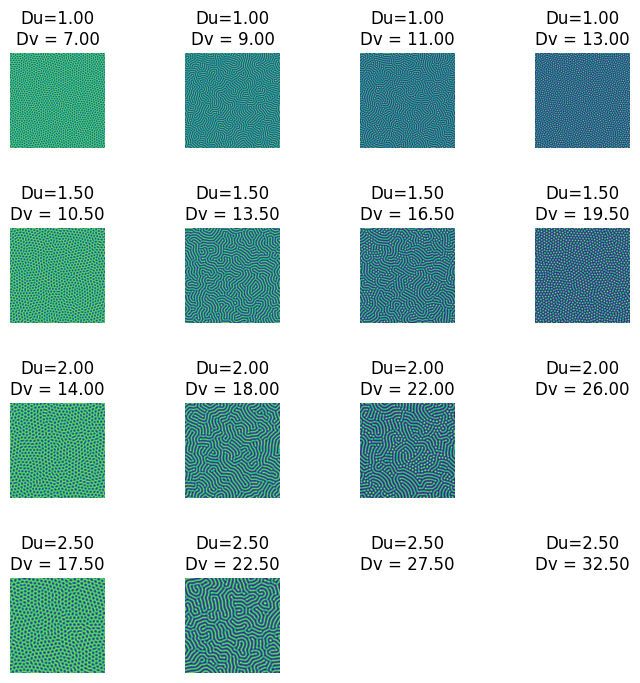

In [39]:
ab_grid(df, 50_000, 0.0025, 400, 0.5, frame=-1, var1="Du", var2="Dv")

In [13]:
def snapshot_grid(df, column, component_idx=0, n_images=5, sigdigits=2):
    df_filtered = df.sort_values(by=column)

    count = len(df_filtered)
    fig = plt.figure(figsize=(20, 24))
    grid = ImageGrid(
        fig,
        111,
        nrows_ncols=(count, n_images),
        axes_pad=0.5,  # pad between Axes in inch.
    )

    ims = []

    for i, row in df_filtered.iterrows():
        ds = nc.Dataset(row["filename"])
        data = ds.variables["data"][:]
        for j in range(n_images):
            frame_idx = int(row["n_snapshots"] * j / n_images)
            ims.append((j, row, data[0, frame_idx, :, component_idx::2]))
    
    for ax, (j, row, im) in zip(grid, ims):
        if j == 0:
            ax.set_title(f"A={row['A']:.{sigdigits}f} B = {row['B']:.{sigdigits}f}")
        else:
            frame_idx = int(row["n_snapshots"] * j / n_images)
            t = row["dt"] * row["Nt"] / row["n_snapshots"] * frame_idx
            ax.set_title(f"t={t:.{sigdigits}f}")
        ax.imshow(im, cmap="viridis")
        ax.set_aspect("equal")
        ax.axis("off")
    
    plt.show()

In [12]:
# df_a = df[df["A"] == 5.0]
# snapshot_grid(df_a, "A")